# Sentiment Analysis (Kaggle)

This challenge is a classification problem for text data that classify phrases (or sentense) on a scale of five values: negative, somewhat negative, neutral, somewhat positive, positive. Obstacles like sentence negation, sarcasm, terseness, language ambiguity, and many others make this task very challenging.

# Dataset

The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

train.tsv contains the phrases and their associated sentiment labels. We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.
test.tsv contains just phrases. You must assign a sentiment label to each phrase.
The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

## 1. Data Preparation

Import necessary libraries and load the data using pandas

In [224]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,GRU,LSTM,Embedding
from keras.optimizers import Adam
from keras.layers import SpatialDropout1D,Dropout,Bidirectional,Conv1D,GlobalMaxPooling1D,MaxPooling1D,Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

In [189]:
train_movie_data = pd.read_csv('Rotten_Tomatoes_Dataset/train.tsv', sep = '\t')
test_movie_data = pd.read_csv('Rotten_Tomatoes_Dataset/test.tsv', sep = '\t')

## 1.1 Data Exploration

- Draw classes distribution: we can see that there are an imbalance between classes, most sentences are labeled with natural sentiment. Thus we will use matrics of f1-score, precision, recall instead of accuracy
- Draw the most frequent words in negative sentences and positive sentences. We can see that, there are many punctuation and common words which are not usefull in sentiment analysis. We will remove them in the data preprocessing step.
- We count the number of words in each sentence then draw the distribution of length of sentence.

In [190]:
train_movie_data.columns

Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')

In [191]:
train_movie_data.dtypes

PhraseId       int64
SentenceId     int64
Phrase        object
Sentiment      int64
dtype: object

In [192]:
print(train_movie_data.shape, test_movie_data.shape)
train_movie_data.head(10)

(156060, 4) (66292, 3)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


### Classes Distribution

Text(0, 0.5, 'Number of reviews')

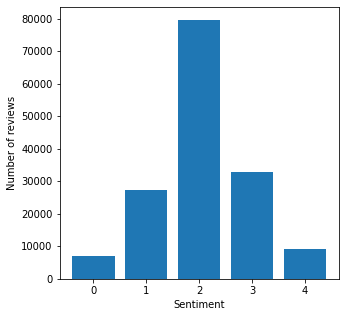

In [193]:
sentiment_count = train_movie_data['Sentiment'].value_counts()

plt.figure(figsize=(5,5))
plt.bar(sentiment_count.index, sentiment_count.values)
plt.xlabel('Sentiment')
plt.ylabel('Number of reviews')


### Words Frequency

In [194]:
#  For negative sentence
def get_all_words(sentenses):
    for sentense in sentenses:
        for word in sentense.split():
            yield word

neg_sentenses = train_movie_data[train_movie_data['Sentiment'] == 0]['Phrase']
all_neg_words = get_all_words(neg_sentenses)

In [195]:
from nltk import FreqDist

freq_dist_neg = FreqDist(all_neg_words)
print(freq_dist_neg.most_common(20))

[(',', 3722), ('the', 3070), ('a', 2572), ('and', 2507), ('of', 2236), ('.', 1973), ('to', 1880), ('is', 1363), ("'s", 1136), ('that', 1130), ('in', 998), ('it', 927), ('movie', 757), ('as', 738), ('this', 576), ('for', 509), ('its', 488), ('film', 477), ('with', 437), ("n't", 424)]


In [196]:
#  For positive sentence

pos_sentenses = train_movie_data[train_movie_data['Sentiment'] == 4]['Phrase']
all_pos_words = get_all_words(pos_sentenses)

freq_dist_pos = FreqDist(all_pos_words)
print(freq_dist_pos.most_common(20))

[(',', 4879), ('and', 3968), ('the', 3819), ('a', 3311), ('of', 3022), ('.', 2280), ('is', 1547), ('to', 1540), ("'s", 1329), ('that', 1248), ('in', 1045), ('film', 930), ('with', 912), ('it', 739), ('as', 713), ('an', 664), ('movie', 564), ('for', 553), ('A', 520), ('its', 516)]


### Length of Sentences Distribution

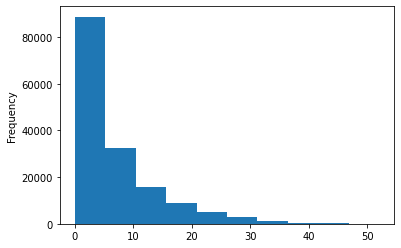

In [197]:
train_movie_data['LengthSentence'] = train_movie_data['Phrase'].apply(lambda x: len(x.split()))
train_movie_data['LengthSentence'].plot(kind = 'hist')

## 1.2 Data Pre-Processing

### Lower case
We need to lower case all words in sentences that to avoid having many copies of the same words.

In [198]:
train_movie_data['Phrase'] = train_movie_data['Phrase'].apply(lambda x: " ".join(w.lower() for w in x.split()))
test_movie_data['Phrase'] = test_movie_data['Phrase'].apply(lambda x: " ".join(w.lower() for w in x.split()))

### Removing Punctuation
Punctuations are useless in sentiment analysis, therefore we should remove them

In [199]:
train_movie_data['Phrase'] = train_movie_data['Phrase'].str.replace('[^\w\s]','')
test_movie_data['Phrase'] = test_movie_data['Phrase'].str.replace('[^\w\s]','')

### Removing Stop Words
Stop words are commonly occurring words that should be removed in this context because they are also useless in sentiment alanysis

In [200]:
# from nltk.corpus import stopwords

# SW = stopwords.words('english')
# train_movie_data['Phrase'] = train_movie_data['Phrase'].apply(lambda x: " ".join(w for w in x.split() if w not in SW))
# test_movie_data['Phrase'] = test_movie_data['Phrase'].apply(lambda x: " ".join(w for w in x.split() if w not in SW))

### Lemmatization
we dont want a word can be in different forms, for example (go, goes, went, gone). It can make the vocabulary and vectorizer bigger, but dont have any extra meaning in sentiment analysis.

Lemmatization is a method that converts the word into its root word.

In [201]:
from textblob import Word
train_movie_data['Phrase'] = train_movie_data['Phrase'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
test_movie_data['Phrase'] = test_movie_data['Phrase'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

### Words frequency
After counting the most frequent words in negative sentences and positive sentences, we can see that there are some words like "movie" and "film" occurred mostly but dont have any effect in sentiment analysis.

Therefore we should use Tfidf-vectorizer instead of CountVectorizer

In [202]:
neg_freq = pd.Series(' '.join(train_movie_data[train_movie_data['Sentiment'] == 0]['Phrase']).split()).value_counts()[:20]
neg_freq

a        3537
the      3415
and      2512
of       2242
to       1891
it       1570
is       1368
that     1138
s        1136
in       1023
movie     829
this      652
film      542
for       519
an        467
with      452
you       437
bad       434
nt        424
or        378
dtype: int64

In [203]:
pos_freq = pd.Series(' '.join(train_movie_data[train_movie_data['Sentiment'] == 4]['Phrase']).split()).value_counts()[:20]
pos_freq

a              4563
the            4192
and            3970
of             3024
is             1550
to             1545
it             1385
s              1329
that           1260
film           1091
in             1058
with            929
an              746
movie           746
for             559
this            538
one             507
performance     472
most            440
you             393
dtype: int64

### Train Test Splitting


In [205]:
y = train_movie_data['Sentiment']
X_test = test_movie_data['Phrase']
X_train , X_val , y_train , y_val = train_test_split(train_movie_data['Phrase'],y,test_size = 0.20)

### Vectorize

In [207]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

vectorizer = TfidfVectorizer(ngram_range=(1, 3), tokenizer=tokenizer.tokenize)
vectorizer.fit(X_train)
train_vectorized = vectorizer.transform(X_train)
val_vectorized = vectorizer.transform(X_val)
test_vectorized = vectorizer.transform(X_test)

# 2. Model Selection

As we see above, our dataset is an imbalanced dataset. When working with an imbalanced dataset, the minority classes are typically of the most interest. This means that the model's ability in correctly predicting the label of probability for the minority classes is more important than the majority classes. We use both F1-score and accuracy as matrics for this problem

We perform a baseline model by using linear svm model with "TfidfVectorizer". Then we try with deep network models (GRU and LSTM) and make comparison.


## SVM

In [208]:
svm = LinearSVC()
svm.fit(train_vectorized,y_train)
print(classification_report( svm.predict(val_vectorized) , y_val))
print(accuracy_score( svm.predict(val_vectorized) , y_val ))

              precision    recall  f1-score   support

           0       0.39      0.49      0.44      1079
           1       0.51      0.56      0.53      5028
           2       0.81      0.73      0.77     17729
           3       0.53      0.57      0.55      5984
           4       0.41      0.55      0.47      1392

    accuracy                           0.66     31212
   macro avg       0.53      0.58      0.55     31212
weighted avg       0.68      0.66      0.66     31212

0.6566705113417917


## GRU

In [215]:
# get the unique words of train set as vocab

unique_words = pd.Series(' '.join(train_movie_data['Phrase']).split()).value_counts()
print(len(unique_words))


15048


In [216]:
max_features = len(unique_words)
max_words = 50
batch_size = 128
epochs = 10
num_classes=5

In [217]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [218]:
X_train =pad_sequences(X_train, maxlen=max_words)
X_val = pad_sequences(X_val, maxlen=max_words)
X_test = pad_sequences(X_test, maxlen=max_words)

In [220]:
from keras.utils import to_categorical

y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

In [221]:
# define an early stopping
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)

In [233]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [225]:
model_GRU=Sequential()
model_GRU.add(Embedding(max_features,100,mask_zero=True))
model_GRU.add(GRU(64,dropout=0.5,return_sequences=True))
model_GRU.add(GRU(32,dropout=0.5,return_sequences=False))
model_GRU.add(Dense(100,activation='relu'))
model_GRU.add(Dropout(0.5))
model_GRU.add(Dense(num_classes,activation='softmax'))
model_GRU.compile(loss='categorical_crossentropy',optimizer=Adam(lr = 0.001),metrics=[f1, 'accuracy'])
model_GRU.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 100)         1504800   
_________________________________________________________________
gru_19 (GRU)                 (None, None, 64)          31680     
_________________________________________________________________
gru_20 (GRU)                 (None, 32)                9312      
_________________________________________________________________
dense_15 (Dense)             (None, 100)               3300      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 505       
Total params: 1,549,597
Trainable params: 1,549,597
Non-trainable params: 0
___________________________________________

In [226]:
history_GRU=model_GRU.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat),epochs=epochs, batch_size=batch_size, verbose=1, callbacks = [early_stopping])

Train on 124848 samples, validate on 31212 samples
Epoch 1/10
124848/124848 [==============================] - 152s 1ms/step - loss: 1.0691 - accuracy: 0.5745 - val_loss: 0.8761 - val_accuracy: 0.6379
Epoch 2/10
124848/124848 [==============================] - 147s 1ms/step - loss: 0.8472 - accuracy: 0.6518 - val_loss: 0.8306 - val_accuracy: 0.6585
Epoch 3/10
124848/124848 [==============================] - 149s 1ms/step - loss: 0.7881 - accuracy: 0.6773 - val_loss: 0.8241 - val_accuracy: 0.6639
Epoch 4/10
124848/124848 [==============================] - 152s 1ms/step - loss: 0.7498 - accuracy: 0.6910 - val_loss: 0.8201 - val_accuracy: 0.6639
Epoch 5/10
124848/124848 [==============================] - 143s 1ms/step - loss: 0.7221 - accuracy: 0.7016 - val_loss: 0.8171 - val_accuracy: 0.6698
Epoch 6/10
124848/124848 [==============================] - 136s 1ms/step - loss: 0.7008 - accuracy: 0.7094 - val_loss: 0.8261 - val_accuracy: 0.6659
Epoch 7/10
124848/124848 [=======================

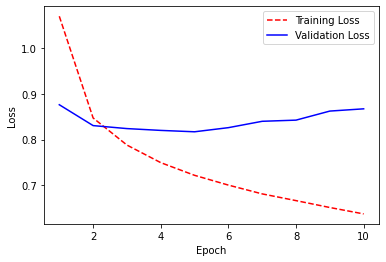

In [227]:
epoch_count = range(1, len(history_GRU.history['loss']) + 1)

plt.plot(epoch_count, history_GRU.history['loss'], 'r--')
plt.plot(epoch_count, history_GRU.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [228]:
y_val_pred = model_GRU.predict_classes(X_val, verbose=1)
print(classification_report( y_val_pred , y_val))
print(accuracy_score( y_val_pred , y_val ))

31212/31212 [==============================] - 15s 480us/step
              precision    recall  f1-score   support

           0       0.31      0.56      0.40       748
           1       0.64      0.54      0.58      6556
           2       0.76      0.77      0.77     15710
           3       0.61      0.57      0.59      6871
           4       0.42      0.60      0.50      1327

    accuracy                           0.67     31212
   macro avg       0.55      0.61      0.57     31212
weighted avg       0.68      0.67      0.67     31212

0.6665385108291683


## LSTM

In [234]:
model_LSTM=Sequential()
model_LSTM.add(Embedding(max_features,100,mask_zero=True))
model_LSTM.add(LSTM(64,dropout=0.5,return_sequences=True))
model_LSTM.add(LSTM(32,dropout=0.5,return_sequences=False))
model_LSTM.add(Dense(100,activation='relu'))
model_LSTM.add(Dropout(0.5))
model_LSTM.add(Dense(num_classes,activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy',optimizer=Adam(lr = 0.001),metrics=[f1, 'accuracy'])
model_LSTM.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 100)         1504800   
_________________________________________________________________
lstm_13 (LSTM)               (None, None, 64)          42240     
_________________________________________________________________
lstm_14 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_21 (Dense)             (None, 100)               3300      
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 505       
Total params: 1,563,261
Trainable params: 1,563,261
Non-trainable params: 0
___________________________________________

In [235]:
history_LSTM=model_LSTM.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat),epochs=epochs, batch_size=batch_size, verbose=1, callbacks = [early_stopping])

Train on 124848 samples, validate on 31212 samples
Epoch 1/10
124848/124848 [==============================] - 151s 1ms/step - loss: 1.0953 - f1: 0.4789 - accuracy: 0.5671 - val_loss: 0.8962 - val_f1: 0.5728 - val_accuracy: 0.6375
Epoch 2/10
124848/124848 [==============================] - 149s 1ms/step - loss: 0.8566 - f1: 0.6145 - accuracy: 0.6532 - val_loss: 0.8414 - val_f1: 0.6178 - val_accuracy: 0.6529
Epoch 3/10
124848/124848 [==============================] - 151s 1ms/step - loss: 0.7949 - f1: 0.6474 - accuracy: 0.6759 - val_loss: 0.8263 - val_f1: 0.6314 - val_accuracy: 0.6603
Epoch 4/10
124848/124848 [==============================] - 150s 1ms/step - loss: 0.7574 - f1: 0.6676 - accuracy: 0.6895 - val_loss: 0.8244 - val_f1: 0.6365 - val_accuracy: 0.6620
Epoch 5/10
124848/124848 [==============================] - 151s 1ms/step - loss: 0.7303 - f1: 0.6809 - accuracy: 0.6987 - val_loss: 0.8241 - val_f1: 0.6541 - val_accuracy: 0.6638
Epoch 6/10
124848/124848 [=======================

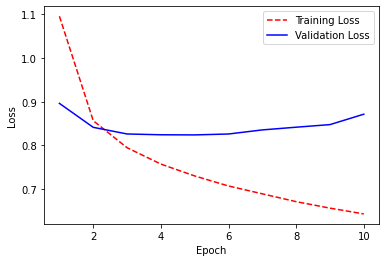

In [237]:
epoch_count = range(1, len(history_LSTM.history['loss']) + 1)

plt.plot(epoch_count, history_LSTM.history['loss'], 'r--')
plt.plot(epoch_count, history_LSTM.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [239]:
y_val_pred = model_LSTM.predict_classes(X_val, verbose=1)
print(classification_report( y_val_pred , y_val))
print(accuracy_score( y_val_pred , y_val ))

31212/31212 [==============================] - 14s 439us/step
              precision    recall  f1-score   support

           0       0.36      0.53      0.43       935
           1       0.61      0.54      0.57      6265
           2       0.75      0.77      0.76     15546
           3       0.63      0.56      0.59      7209
           4       0.41      0.61      0.49      1257

    accuracy                           0.66     31212
   macro avg       0.55      0.60      0.57     31212
weighted avg       0.67      0.66      0.67     31212

0.6645841343073177


# 3. Evaluation

The performance of GRU and LSTM are same, and better than linear SVM

In [242]:
# get prediction on test set for submission
y_pred=model_LSTM.predict_classes(X_test)

sub_file = pd.read_csv('Rotten_Tomatoes_Dataset/sampleSubmission.csv',sep=',')
sub_file.Sentiment=y_pred
sub_file.to_csv('Submission.csv',index=False)